### Python setup

See `README.md` for python environment setup instructions on OSX using `pyenv` in VSCode.  If you've got another way of getting a modern, viable python environment, feel free to use it.

Here are the versions that I'm using when running this notebook:

In [18]:
import platform
import psutil

print(platform.python_version())

memory_info = psutil.virtual_memory()
print(f"Total memory: {memory_info.total / (1024 ** 3):.2f} GB")
print(f"Available memory: {memory_info.available / (1024 ** 3):.2f} GB")
print(f"Used memory: {memory_info.used / (1024 ** 3):.2f} GB")
print(f"Memory percent: {memory_info.percent}%")

3.12.2
Total memory: 64.00 GB
Available memory: 33.08 GB
Used memory: 22.09 GB
Memory percent: 48.3%


In [2]:
# install dependencies with `pip` 
! pip install requests pandas matplotlib polars pyarrow

### Generate a self-signed cert that we can use for the https redirect during the OAuth login

You'll need to tell your browser to "trust" this cert after the redirect

In [3]:
import os
import subprocess
import shutil
from IPython import get_ipython

def generate_key():
    if shutil.which("openssl") is None:
        print("openssl is not found. Please install openssl and make sure it's on your system path. See: https://wiki.openssl.org/index.php/Binaries")
        return

    if os.path.isfile("key.pem"):
        print("key.pem already exists, not regenerating it. Delete it if you'd like to regenerate it.")
    else:
        command = 'openssl req -x509 -newkey rsa:4096 -keyout key.pem -out cert.pem -days 365 -nodes -subj "/C=US/ST=California/L=San Francisco/O=My Company/OU=My Division/CN=localhost"'
        process = subprocess.Popen(command, shell=True)
        process.wait()

generate_key()

key.pem already exists, not regenerating it. Delete it if you'd like to regenerate it.


### API Key and Client ID

You'll need an API Key and Client ID to interact with Bungie's API.  You can generate one on Bungie's website: https://www.bungie.net/en/Application

You can generate an application with the "Public" OAuth type with a redirect url of: `https://localhost:7777/oauth-redirect`  - this will be used after the oauth login to get the oauth token that will be used in API requests

The only scope necessary is read access: `Read your Destiny 2 information (Vault, Inventory, and Vendors), as well as Destiny 1 Vault and Inventory data` 

This is what it should look like:

![Image](images/oauth-app-settings.png)


Once you create your application, you should get an `OAuth client_id` and an `API Key`, values for these should be put into `config.json` along with your Bungie `username` (Steam usernames will have a 4-digit hash like `#1234` on the end).  It should look like this:

```
{ "client_id": "your_client_id", "api_key": "your_api_key", "username": "your_username#1234"}
```

This same username is used on things like https://dungeon.report to find your user.

This next cell will read that file in and make the `client_id`, `api_key`, and `username` values available to the rest of the calls.


In [4]:
from src import config

client_id, api_key, username = config.load_config()

print(f"client_id length: {len(client_id)}")
print(f"api_key length: {len(api_key)}")
print(f"username: {username}")

client_id length: 5
api_key length: 32
username: ted#2434


### Login with OAuth to get a token that'll last for 1 hour

In [5]:
from src.bungie_oauth import BungieAuth
import datetime

# perform oauth login to get the access token used in later requests.  It is good for 1 hour
print("We're using a self-signed certificate to run an HTTPS server on localhost, you'll need to accept the certificate in your browser.")
access_token = BungieAuth(client_id).refresh_oauth_token()

# token is good for 1 hour, print out the time that it expires
expiration_time = datetime.datetime.now() + datetime.timedelta(hours=1)
print(f"Access token successfully acquired at: {datetime.datetime.now().isoformat()} and expires at: {expiration_time.isoformat()}")

We're using a self-signed certificate to run an HTTPS server on localhost, you'll need to accept the certificate in your browser.
Please go to the following URL and authorize the app: https://www.bungie.net/en/oauth/authorize?client_id=22927&response_type=code&state=3q2TRp2Etv6Y3KRzwYqOUozfok8YNYd9096RxSKbDut6bt_sJu4qL5_ca1Xh_ljsbWrwdL_4G3DZaSuxnY-KuaWipisQIPS_O6X0Phdi1jsgVZc6cywJqTJ_3aWNX38_W_dL0lUgA9-iP4EcAv7WXe-Fc7EzSccDZTi5WZ96DT4=&redirect_uri=https://localhost:7777/
Stopping HTTPS server
Access token successfully acquired at: 2024-05-27T23:18:18.174129 and expires at: 2024-05-28T00:18:18.174077


### Now we're ready to talk to Bungie's API

In [6]:
from src.bungie_api import BungieApi

api = BungieApi(api_key, access_token)

membership_id, profile_type = api.get_primary_membership_id_and_type(username)
print(f"Membership ID: {membership_id}, Profile Type: {profile_type}")

api.get_character_ids_and_classes(membership_id, profile_type)

Checking membership ID 4611686018436088066 with membership type 2
Crosave override found for 4611686018436088066
Membership ID: 4611686018436088066, Profile Type: 2


{'2305843009262789149': 'Titan',
 '2305843009262789151': 'Warlock',
 '2305843009665494246': 'Hunter'}

In [7]:
# retrieve the manifest and item/stat definitions that will be joined with profile data to determine what armor you have in your vault
item_definitions, stat_definitions = api.get_static_definitions()

In [8]:
import os
import json

# access_token, profile_type, and membership_id should be retrieved above 
# using the login_and_get_token and get_primary_membership_id_and_type functions

# https://bungie-net.github.io/multi/schema_Destiny-DestinyComponentType.html#schema_Destiny-DestinyComponentType
# 100 = profile.data.userInfo
# 102 = profileInventory.data.items
# 201 = characterInventories.data[character_id].items
# 205 = characterEquipment.data[character_id].items
# 300 = itemComponents.instances
# 305 = profilePlugSets.data.plugs, characterPlugSets.data[character_id].plugs, itemComponents.sockets

# this gives us all of the information we need for vault armor for this user
profile = api.get_profile(access_token, profile_type, membership_id, [100,102,201,205,300,305,309])

os.makedirs('data', exist_ok=True)

# dump the profile out as json into the data directory
with open('data/profile.json', 'w') as file:
    json.dump(profile, file, indent=4)

print(f"Character profile loaded at:", profile["responseMintedTimestamp"])

Character profile loaded at: 2024-05-28T04:17:21.026Z


In [9]:
# extract all armor pieces out of the profile.  It retrieves from the vault, character inventory, and character equipment
import src.armor as armor
import pandas as pd

profile_armor = armor.ProfileArmor(profile, item_definitions, stat_definitions)

armor_dict = profile_armor.get_armor_dict()

armor_df = pd.DataFrame([{
    **vars(armor), 
    'total_stats': armor.total_stats,
    'is_exotic': armor.is_exotic,
    'class_slot': armor.class_slot
} for armor in armor_dict.values()])

armor_df

,item_name,item_hash,instance_id,rarity,slot,power,mobility,resilience,recovery,discipline,intellect,strength,is_artifice,is_masterworked,d2_class,total_stats,is_exotic,class_slot
0,Tusked Allegiance Helmet,2240729575,6917529815104854677,Legendary,Helmet,1810,2,23,7,21,10,2,False,True,Titan,65,False,Titan Helmet
1,Synthoceps,241462142,6917529871224003792,Exotic,Gauntlets,1810,2,16,13,17,2,10,False,True,Titan,60,True,Titan Gauntlets
2,Warmind's Avatar Chestplate,839296981,6917529857906618905,Legendary,Chest Armor,1810,2,30,2,15,10,6,False,True,Titan,65,False,Titan Chest Armor
3,Ketchkiller's Greaves,1640403802,6917529823402521839,Legendary,Leg Armor,1809,6,22,6,23,8,2,False,True,Titan,67,False,Titan Leg Armor
4,Descending Echo Mark,4050474396,6917529942979833410,Legendary,Class Item,1810,0,0,0,0,0,0,True,True,Titan,0,False,Titan Class Item
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,Techeun's Regalia Robes,988330314,6917530015482268034,Legendary,Chest Armor,1800,16,16,2,2,22,9,False,False,Warlock,67,False,Warlock Chest Armor
342,Techeun's Regalia Boots,2549387168,6917530015482271242,Legendary,Leg Armor,1800,12,16,6,2,20,9,False,False,Warlock,65,False,Warlock Leg Armor
343,Techeun's Regalia Boots,2549387168,6917530015478829219,Legendary,Leg Armor,1800,2,23,8,7,24,2,False,False,Warlock,66,False,Warlock Leg Armor
344,Techeun's Regalia Boots,2549387168,6917530015478827474,Legendary,Leg Armor,1800,16,2,12,7,24,2,False,False,Warlock,63,False,Warlock Leg Armor


In [10]:
# specific instances of armor in my vault used for spot testing - these will only be in Ted's vault
crown_of_tempests_id=6917529798174050595
corrupting_echo_gloves_id=6917529970716463834
ketchkillers_robes_id=6917529822099480651
deep_explorer_boots_id=6917529796979541985
class_item_id=6917529583788947730
armor_df[armor_df['instance_id'].isin([crown_of_tempests_id, corrupting_echo_gloves_id, ketchkillers_robes_id, deep_explorer_boots_id, class_item_id])]

,item_name,item_hash,instance_id,rarity,slot,power,mobility,resilience,recovery,discipline,intellect,strength,is_artifice,is_masterworked,d2_class,total_stats,is_exotic,class_slot
39,Corrupting Echo Bond,4217390949,6917529583788947730,Legendary,Class Item,1810,0,0,0,0,0,0,True,True,Warlock,0,False,Warlock Class Item
248,Crown of Tempests,3381022969,6917529798174050595,Exotic,Helmet,1810,2,30,2,16,2,16,False,True,Warlock,68,True,Warlock Helmet
262,Corrupting Echo Gloves,2244604734,6917529970716463834,Legendary,Gauntlets,1810,8,9,16,12,2,20,True,True,Warlock,67,False,Warlock Gauntlets
268,Ketchkiller's Robes,3833868247,6917529822099480651,Legendary,Chest Armor,1810,6,22,6,20,12,2,False,True,Warlock,68,False,Warlock Chest Armor
273,Deep Explorer Boots,2819810688,6917529796979541985,Legendary,Leg Armor,1810,2,26,6,22,9,2,True,True,Warlock,67,False,Warlock Leg Armor


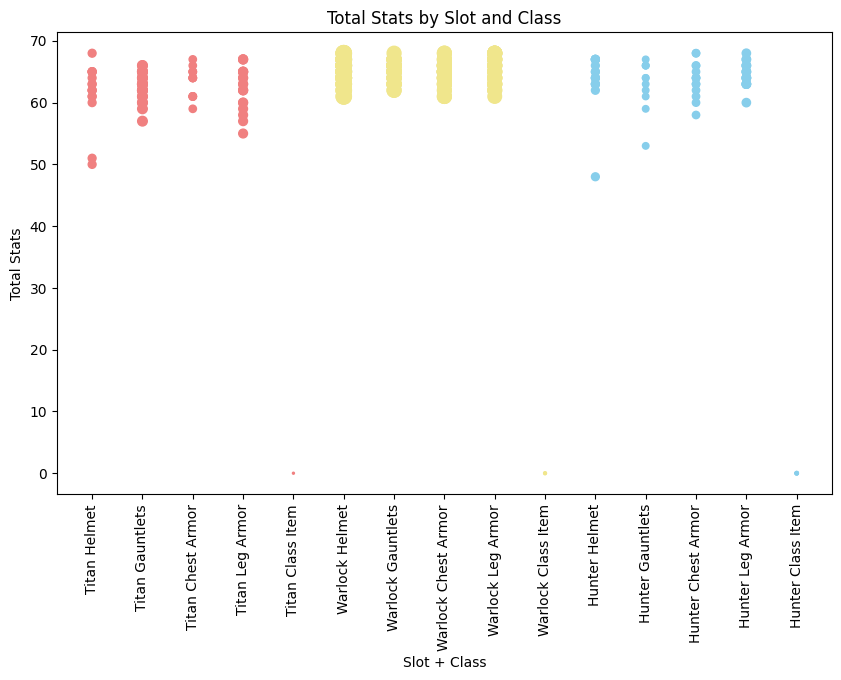

In [11]:
# create a graph that shows total stats by class and slot for all armor in the vault.  The larger the circle, the more we have with that stat total
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a color map for the classes
color_map = {'Hunter': mcolors.CSS4_COLORS['skyblue'], 
             'Titan': mcolors.CSS4_COLORS['lightcoral'], 
             'Warlock': mcolors.CSS4_COLORS['khaki']}
armor_df['color'] = armor_df['d2_class'].map(color_map)

# Calculate the counts for each 'class_slot' value
counts = armor_df['class_slot'].value_counts()

plt.figure(figsize=(10,6))
# Pass the counts as the 's' argument to plt.scatter()
plt.scatter(armor_df['class_slot'], armor_df['total_stats'], s=counts[armor_df['class_slot']] * 2, color=armor_df['color'])
plt.xlabel('Slot + Class')
plt.ylabel('Total Stats')
plt.title('Total Stats by Slot and Class')
plt.xticks(rotation=90)
plt.show()

In [12]:
from itertools import product
from collections import defaultdict
from collections import namedtuple
import numpy as np

class ProfileOutfits:

    # masterworking helmet, gauntlets, chest armor, leg armor, and class item gives a +10 bonus to each stat in an outfit
    FULL_MASTERWORK_STAT_BONUS = 10
    
    NO_EXOTIC_HASH = -1

    def __init__(self, armor_dict):
        self.armor_dict = armor_dict
        self.artifice_permutations = {i: self.generate_artifice_permutations(i) for i in range(6)}

    # we want to generate outfits for a given class
    # The high-level algorithm is:

    # 1. filter armor to only include armor for the given class, also filter out class items
    # 2. segregate the armor by whether it is exotic or not
    # 3. group the exotic and non-exotic armor by slot
    def filter_and_group_armor(self, d2_class, slots = ["Helmet", "Gauntlets", "Chest Armor", "Leg Armor", "Class Item"]):
        exotic_armor = defaultdict(list)
        non_exotic_armor = defaultdict(list)
        for armor in self.armor_dict.values():
            if armor.d2_class == d2_class and armor.slot in slots:
                if armor.is_exotic:
                    exotic_armor[armor.slot].append(armor)
                else:
                    non_exotic_armor[armor.slot].append(armor)

        if "Class Item" in non_exotic_armor:
            # class items all have the same stats, the only option is if one is artifice.  Pick one and remove the rest
            for armor in non_exotic_armor["Class Item"]:
                if armor.is_artifice:
                    non_exotic_armor["Class Item"] = [armor]
                    break

            if len(non_exotic_armor["Class Item"]) > 1:
                non_exotic_armor["Class Item"] = [non_exotic_armor["Class Item"][0]]

        return exotic_armor, non_exotic_armor

    # 4. generate all possible outfits using non-exotic armor
    # 5. add in all possible outfits using a single piece of exotic armor
    def generate_class_outfits(self, d2_class):
        outfits = []

        # filter armor to only include armor for the given class and slots
        exotic_armor, non_exotic_armor = self.filter_and_group_armor(d2_class, ["Helmet", "Gauntlets", "Chest Armor", "Leg Armor", "Class Item"])

        # append all possible non-exotic armor combinations

        # do we care about non-exotic armor?
        self.append_outfit_permutations(outfits, non_exotic_armor["Helmet"], non_exotic_armor["Gauntlets"], non_exotic_armor["Chest Armor"], non_exotic_armor["Leg Armor"], non_exotic_armor["Class Item"])

        # we can only have exotic armor in a single slot, add all outfits with a single slot of exotic armor
        self.append_outfit_permutations(outfits, exotic_armor["Helmet"], non_exotic_armor["Gauntlets"], non_exotic_armor["Chest Armor"], non_exotic_armor["Leg Armor"], non_exotic_armor["Class Item"])
        self.append_outfit_permutations(outfits, non_exotic_armor["Helmet"], exotic_armor["Gauntlets"], non_exotic_armor["Chest Armor"], non_exotic_armor["Leg Armor"], non_exotic_armor["Class Item"])
        self.append_outfit_permutations(outfits, non_exotic_armor["Helmet"], non_exotic_armor["Gauntlets"], exotic_armor["Chest Armor"], non_exotic_armor["Leg Armor"], non_exotic_armor["Class Item"])
        self.append_outfit_permutations(outfits, non_exotic_armor["Helmet"], non_exotic_armor["Gauntlets"], non_exotic_armor["Chest Armor"], exotic_armor["Leg Armor"], non_exotic_armor["Class Item"])

        # as of right now, there is no exotic class item.  there will be in TFS, but unless it has stats better than a legendary class item, we don't care
        # append_outfit_permutations(outfits, non_exotic_armor["Helmet"], non_exotic_armor["Gauntlets"], non_exotic_armor["Chest Armor"], non_exotic_armor["Leg Armor"], exotic_armor["Class Item"])

        return outfits

    def generate_artifice_permutations(self, num_artifice):
        # Generate all permutations artifice mods that could be assigned to each stat
        all_permutations = product(range(0, num_artifice + 1), repeat=6)

        # Filter the permutations to only include ones with that have the right number of artifice applied
        valid_permutations = [perm for perm in all_permutations if sum(perm) == num_artifice]

        # for each artifice in a slot, it applies a +3 bonus to that stat
        return [tuple(i*3 for i in perm) for perm in valid_permutations]


    def round_to_useful_tier(self, stat):
        # stats above 100 aren't useful.  T10 is the highest tier
        if stat > 100:
            return 100

        # half tiers can be useful as there are 5 point mods, so we want to round down to the nearest 5
        return stat - (stat % 5)



    def append_outfit_permutations(self, outfits, helmets, gauntlets, chest_armors, leg_armors, class_items):
        for helmet, gauntlet, chest_armor, leg_armor, class_item in product(helmets, gauntlets, chest_armors, leg_armors, class_items):
            # we want to add the masterwork stat bonus
            # armor pieces have base stats, without any mods or masterworking
            base_mobility = self.FULL_MASTERWORK_STAT_BONUS + helmet.mobility + gauntlet.mobility + chest_armor.mobility + leg_armor.mobility + class_item.mobility
            base_resilience = self.FULL_MASTERWORK_STAT_BONUS + helmet.resilience + gauntlet.resilience + chest_armor.resilience + leg_armor.resilience + class_item.resilience
            base_recovery = self.FULL_MASTERWORK_STAT_BONUS + helmet.recovery + gauntlet.recovery + chest_armor.recovery + leg_armor.recovery + class_item.recovery
            base_discipline = self.FULL_MASTERWORK_STAT_BONUS + helmet.discipline + gauntlet.discipline + chest_armor.discipline + leg_armor.discipline + class_item.discipline
            base_intellect = self.FULL_MASTERWORK_STAT_BONUS + helmet.intellect + gauntlet.intellect + chest_armor.intellect + leg_armor.intellect + class_item.intellect
            base_strength = self.FULL_MASTERWORK_STAT_BONUS + helmet.strength + gauntlet.strength + chest_armor.strength + leg_armor.strength + class_item.strength

            num_artifice = helmet.is_artifice + gauntlet.is_artifice + chest_armor.is_artifice + leg_armor.is_artifice + class_item.is_artifice

            # should be at most one exotic armor piece in an outfit
            exotic_hash = self.NO_EXOTIC_HASH
            for armor in [helmet, gauntlet, chest_armor, leg_armor, class_item]:
                if armor.is_exotic:
                    exotic_hash = armor.item_hash
                    break

            self.append_outfit_permutation(outfits, 
                                           base_mobility, 
                                           base_resilience, 
                                           base_recovery, 
                                           base_discipline, 
                                           base_intellect, 
                                           base_strength, 
                                           helmet.instance_id, 
                                           gauntlet.instance_id, 
                                           chest_armor.instance_id, 
                                           leg_armor.instance_id, 
                                           class_item.instance_id, 
                                           exotic_hash, 
                                           num_artifice)

    # recursively apply any artifice to the outfit
    def append_outfit_permutation(self, outfits, mobility, resilience, recovery, discipline, intellect, strength, helmet, gauntlets, chest_armor, leg_armor, class_item, exotic_hash, num_artifice):
        if num_artifice == 0:
            outfits.append((
                self.round_to_useful_tier(mobility),
                self.round_to_useful_tier(resilience),
                self.round_to_useful_tier(recovery),
                self.round_to_useful_tier(discipline),
                self.round_to_useful_tier(intellect),
                self.round_to_useful_tier(strength),
                helmet,
                gauntlets,
                chest_armor,
                leg_armor,
                class_item,
                exotic_hash,
                num_artifice
            ))
        else:

            # create a set of stats that we can use to only build outfits with a unique set of stats, some combinations don't create unique useful tiers
            # ex: if mobility is 27 adding +3 is the same as adding +6, they both round to 30
            useful_stats_permutations = set()

            for artifice_bonus in self.artifice_permutations[num_artifice]:
                useful_stats_permutations.add(
                    (
                        self.round_to_useful_tier(mobility + artifice_bonus[0]),
                        self.round_to_useful_tier(resilience + artifice_bonus[1]),  
                        self.round_to_useful_tier(recovery + artifice_bonus[2]),  
                        self.round_to_useful_tier(discipline + artifice_bonus[3]),
                        self.round_to_useful_tier(intellect + artifice_bonus[4]),
                        self.round_to_useful_tier(strength + artifice_bonus[5])
                    )
                )
            for useful_stats in useful_stats_permutations:
                outfits.append((
                    useful_stats[0],
                    useful_stats[1],
                    useful_stats[2],
                    useful_stats[3],
                    useful_stats[4],
                    useful_stats[5],
                    helmet,
                    gauntlets,
                    chest_armor,
                    leg_armor,
                    class_item,
                    exotic_hash,
                    num_artifice
                ))

    # identify all non-class item armor that has the same or worse stats than another piece of armor of the same rarity and type
    def find_eclipsed_armor(self):
        eclipsed_armor = []
        armor_list = list(self.armor_dict.values())

        # sort by power level, low to high
        armor_list.sort(key=lambda x: x.power)

        for i, armor in enumerate(armor_list):
            if armor.slot == "Class Item":
                continue
            for other_armor in armor_list[i+1:]:
                if armor.rarity != other_armor.rarity:
                    continue
                # only compare exotic armor pieces that are the same item
                if armor.rarity == "Exotic" and armor.item_hash != other_armor.item_hash:
                    continue
                if armor.class_slot == other_armor.class_slot and armor.instance_id != other_armor.instance_id:
                    if armor.mobility <= other_armor.mobility and armor.resilience <= other_armor.resilience and armor.recovery <= other_armor.recovery and armor.discipline <= other_armor.discipline and armor.intellect <= other_armor.intellect and armor.strength <= other_armor.strength:
                        eclipsed_armor.append((armor, other_armor))
                    elif other_armor.mobility <= armor.mobility and other_armor.resilience <= armor.resilience and other_armor.recovery <= armor.recovery and other_armor.discipline <= armor.discipline and other_armor.intellect <= armor.intellect and other_armor.strength <= armor.strength:
                        eclipsed_armor.append((other_armor, armor))
        return eclipsed_armor


### Identify all armor that is eclipsed by another piece of armor and can be safely deleted

In [14]:
profile_outfits = ProfileOutfits(armor_dict)

# print out all armor that has the same or worse stats than another piece of armor of the same rarity and type
for lesser_armor, greater_armor in profile_outfits.find_eclipsed_armor():
    print(f"id:{lesser_armor.instance_id} OR id:{greater_armor.instance_id}")
    print(f"mob {lesser_armor.mobility}\tres {lesser_armor.resilience}\trec {lesser_armor.recovery}\tdis {lesser_armor.discipline}\tint {lesser_armor.intellect}\tstr {lesser_armor.strength}\t name {lesser_armor.item_name} <-- can be deleted")
    print(f"mob {greater_armor.mobility}\tres {greater_armor.resilience}\trec {greater_armor.recovery}\tdis {greater_armor.discipline}\tint {greater_armor.intellect}\tstr {greater_armor.strength}\t name {greater_armor.item_name} <-- is equal or better")
    

id:6917529664322015082 OR id:6917529882311993983
mob 20	res 2	rec 10	dis 15	int 15	str 2	 name Tusked Allegiance Mask <-- can be deleted
mob 20	res 2	rec 10	dis 15	int 15	str 2	 name Techeun's Regalia Mask <-- is equal or better
id:6917530015482270736 OR id:6917530015492164116
mob 2	res 6	rec 24	dis 9	int 20	str 2	 name Techeun's Regalia Gloves <-- can be deleted
mob 2	res 7	rec 24	dis 10	int 21	str 2	 name Techeun's Regalia Gloves <-- is equal or better
id:6917530015482267141 OR id:6917530015476010186
mob 2	res 26	rec 2	dis 2	int 20	str 9	 name Techeun's Regalia Robes <-- can be deleted
mob 2	res 27	rec 2	dis 2	int 20	str 12	 name Techeun's Regalia Robes <-- is equal or better
id:6917530015482272117 OR id:6917530015478824342
mob 2	res 12	rec 16	dis 9	int 20	str 2	 name Techeun's Regalia Robes <-- can be deleted
mob 2	res 16	rec 16	dis 10	int 20	str 2	 name Techeun's Regalia Robes <-- is equal or better
id:6917529967583481167 OR id:6917529857906618905
mob 2	res 30	rec 2	dis 15	int 10	s

### Generate all possible outfits for each class type

In [15]:
# uncomment if we want to see only armor that isn't exotic
# non_exotic_armor_dict = {k: v for k, v in armor_dict.items() if not v.is_exotic}
# profile_outfits = ProfileOutfits(non_exotic_armor_dict)

# or use all armor in the vault
profile_outfits = ProfileOutfits(armor_dict)

# generate outfit permutations for each class
d2_class = "Hunter"
hunter_outfits = profile_outfits.generate_class_outfits(d2_class)
print(f"Generated {len(hunter_outfits)} outfit permutations for {d2_class}")

d2_class = "Titan"
titan_outfits = profile_outfits.generate_class_outfits(d2_class)
print(f"Generated {len(titan_outfits)} outfit permutations for {d2_class}")

d2_class = "Warlock"
warlock_outfits = profile_outfits.generate_class_outfits(d2_class)
print(f"Generated {len(warlock_outfits)} outfit permutations for {d2_class}")

Generated 73426 outfit permutations for Hunter
Generated 93296 outfit permutations for Titan
Generated 52299075 outfit permutations for Warlock


In [16]:
# modify to the class you want to work with below
# d2_class, outfits = ("Hunter", hunter_outfits)
# d2_class, outfits = ("Titan", titan_outfits)
d2_class, outfits = ("Warlock", warlock_outfits)

In [17]:
import polars as pl
from polars import col
from itertools import combinations

column_names = ['mobility', 'resilience', 'recovery', 'discipline', 'intellect', 'strength', 'helmet', 'gauntlets', 'chest_armor', 'leg_armor', 'class_item', 'exotic_hash', 'num_artifice']

schema = {}

for column_name in column_names:
    schema[column_name] = pl.Int64

outfits_df = pl.DataFrame(outfits, schema=schema)

# we're creating columns for stat combinations, this weight is used to determine how much that stat is worth in that combination
# we're then adding that stat to all other stats to determine the outfits worth for that combo
# this lets us compare two outfits and allow the spike in one stat to offset some lesser stats in others we don't care about for that combo
# we can then search through and find the maximum values for each combo and keep those and reject outfits/armor pieces that aren't at a max
weight = 10

# Define the stats
stats = ['mobility', 'resilience', 'recovery', 'discipline', 'intellect', 'strength']

# Generate the weighted columns for each combination
weighted_columns = []

for stat_count in range(1, 4):
    combos = list(combinations(stats, stat_count))

    for combo in combos:
        # Create a list of the column expressions for the weighted sum
        column_exprs = [(col(stat) * (weight // stat_count) if stat in combo else col(stat)) for stat in stats]
        
        # Create the alias for the weighted column
        alias = 'weighted_' + '_'.join(combo)
        
        # Add the weighted column to the list
        weighted_columns.append(sum(column_exprs).alias(alias))

# Add the weighted columns to the DataFrame
outfits_df = outfits_df.with_columns(*weighted_columns)

outfits_df


mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,exotic_hash,num_artifice,weighted_mobility,weighted_resilience,weighted_recovery,weighted_discipline,weighted_intellect,weighted_strength,weighted_mobility_resilience,weighted_mobility_recovery,weighted_mobility_discipline,weighted_mobility_intellect,weighted_mobility_strength,weighted_resilience_recovery,weighted_resilience_discipline,weighted_resilience_intellect,weighted_resilience_strength,weighted_recovery_discipline,weighted_recovery_intellect,weighted_recovery_strength,weighted_discipline_intellect,weighted_discipline_strength,weighted_intellect_strength,weighted_mobility_resilience_recovery,weighted_mobility_resilience_discipline,weighted_mobility_resilience_intellect,weighted_mobility_resilience_strength,weighted_mobility_recovery_discipline,weighted_mobility_recovery_intellect,weighted_mobility_recovery_strength,weighted_mobility_discipline_intellect,weighted_mobility_discipline_strength,weighted_mobility_intellect_strength,weighted_resilience_recovery_discipline,weighted_resilience_recovery_intellect,weighted_resilience_recovery_strength,weighted_resilience_discipline_intellect,weighted_resilience_discipline_strength,weighted_resilience_intellect_strength,weighted_recovery_discipline_intellect,weighted_recovery_discipline_strength,weighted_recovery_intellect_strength,weighted_discipline_intellect_strength
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
25,100,40,70,45,40,6917530015488876889,6917529838031225999,6917529850937976682,6917529906176854077,6917529583788947730,-1,2,545,1220,680,950,725,680,820,580,700,600,580,880,1000,900,880,760,660,640,780,760,660,650,710,660,650,590,540,530,600,590,540,740,690,680,750,740,690,630,620,570,630
20,100,45,70,45,40,6917530015488876889,6917529838031225999,6917529850937976682,6917529906176854077,6917529583788947730,-1,2,500,1220,725,950,725,680,800,580,680,580,560,900,1000,900,880,780,680,660,780,760,660,650,700,650,640,590,540,530,590,580,530,750,700,690,750,740,690,640,630,580,630
20,100,45,75,45,35,6917530015488876889,6917529838031225999,6917529850937976682,6917529906176854077,6917529583788947730,-1,2,500,1220,725,995,725,635,800,580,700,580,540,900,1020,900,860,800,680,640,800,760,640,650,710,650,630,600,540,520,600,580,520,760,700,680,760,740,680,650,630,570,630
20,100,40,70,50,40,6917530015488876889,6917529838031225999,6917529850937976682,6917529906176854077,6917529583788947730,-1,2,500,1220,680,950,770,680,800,560,680,600,560,880,1000,920,880,760,680,640,800,760,680,640,700,660,640,580,540,520,600,580,540,740,700,680,760,740,700,640,620,580,640
20,100,40,70,45,40,6917530015488876889,6917529838031225999,6917529850937976682,6917529906176854077,6917529583788947730,-1,2,495,1215,675,945,720,675,795,555,675,575,555,875,995,895,875,755,655,635,775,755,655,635,695,645,635,575,525,515,585,575,525,735,685,675,745,735,685,625,615,565,625
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
70,55,30,25,90,40,6917530015482267339,6917530015482266337,6917530015482268034,6917529965587176122,6917529583788947730,511888814,1,940,805,580,535,1120,670,810,710,690,950,750,650,630,890,690,530,790,590,770,570,830,620,610,740,640,560,690,590,680,580,710,530,660,560,650,550,680,600,500,630,620
75,55,30,25,90,40,6917530015482267339,6917530015482266337,6917530015482268034,6917529965587176122,6917529583788947730,511888814,1,990,810,585,540,1125,675,835,735,715,975,775,655,635,895,695,535,795,595,775,575,835,635,625,755,655,575,705,605,695,595,725,535,665,565,655,555,685,605,505,635,625
70,55,35,25,90,40,6917530015482267339,6917530015482266337,6917530015482268034,6917529965587176122,6917529583788947730,511888814,1,945,810,630,540,1125,675,815,735,695,955,755,675,635,895,695

In [19]:
# find the max value in each of the "weighted" columns grouped by num_artifice, then filter to those rows
outfits_df_max = outfits_df.group_by('exotic_hash').max()
outfits_df_max

exotic_hash,mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,num_artifice,weighted_mobility,weighted_resilience,weighted_recovery,weighted_discipline,weighted_intellect,weighted_strength,weighted_mobility_resilience,weighted_mobility_recovery,weighted_mobility_discipline,weighted_mobility_intellect,weighted_mobility_strength,weighted_resilience_recovery,weighted_resilience_discipline,weighted_resilience_intellect,weighted_resilience_strength,weighted_recovery_discipline,weighted_recovery_intellect,weighted_recovery_strength,weighted_discipline_intellect,weighted_discipline_strength,weighted_intellect_strength,weighted_mobility_resilience_recovery,weighted_mobility_resilience_discipline,weighted_mobility_resilience_intellect,weighted_mobility_resilience_strength,weighted_mobility_recovery_discipline,weighted_mobility_recovery_intellect,weighted_mobility_recovery_strength,weighted_mobility_discipline_intellect,weighted_mobility_discipline_strength,weighted_mobility_intellect_strength,weighted_resilience_recovery_discipline,weighted_resilience_recovery_intellect,weighted_resilience_recovery_strength,weighted_resilience_discipline_intellect,weighted_resilience_discipline_strength,weighted_resilience_intellect_strength,weighted_recovery_discipline_intellect,weighted_recovery_discipline_strength,weighted_recovery_intellect_strength,weighted_discipline_intellect_strength
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
138282166,95,100,100,100,100,100,6917530015492170683,6917530015492169886,6917530015492171847,6917529949798681736,6917529583788947730,4,1180,1230,1230,1235,1220,1225,905,890,1065,1040,1000,950,1130,1080,1125,1125,1080,1040,930,950,830,685,815,775,785,780,765,780,785,785,750,835,790,815,815,820,770,815,825,760,685
2316914168,90,100,100,100,100,100,6917529998335924510,6917530015492169886,6917530015492171847,6917530015492168410,6917529583788947730,4,1135,1235,1230,1230,1230,1230,945,885,1060,1080,975,950,1130,1120,1125,1065,1120,1125,930,950,925,685,835,805,795,755,785,805,785,775,785,820,815,815,830,815,810,805,825,805,685
1030017949,100,100,100,100,100,100,6917529872767153766,6917530015492169886,6917530015492171847,6917530015492168410,6917529583788947730,4,1225,1230,1220,1225,1220,1230,950,890,1085,1115,1015,890,1090,1095,1125,985,1075,1105,870,910,925,685,825,805,815,740,780,805,785,785,805,765,775,785,785,800,805,755,780,780,680
1624882687,100,100,100,100,100,100,6917530015492170683,6917530015492169886,6917530015492171847,6917529998335930864,6917529583788947730,4,1220,1230,1230,1230,1220,1235,925,870,1025,1080,1080,950,1105,1115,1125,1005,1075,1105,870,950,925,685,810,800,805,730,765,785,760,785,800,800,785,825,780,825,815,760,815,800,685
3381022971,95,100,100,100,100,100,6917529729791797298,6917530015492169886,6917530015492171847,6917530015492168410,6917529583788947730,4,1180,1230,1230,1235,1220,1225,910,885,1105,1040,925,930,1130,1060,1100,1125,1100,1085,930,965,830,685,810,770,770,785,770,780,795,785,750,825,790,795,815,820,755,805,825,760,685
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
3844826440,100,100,100,100,100,100,6917530015492170683,6917529950611998258,6917530015492171847,6917530015492168410,6917529583788947730,4,1225,1235,1230,1235,1225,1235,930,930,1085,1080,1095,950,1130,1125,1125,1110,1115,1125,945,950,930,685,825,810,800,780,795,825,795,795,810,830,810,815,830,815,810,795,830,810,685
3844826443,100,100,95,100,100,100,6917530015492170683,6917529950606308371,6917530015492171847,6917530015492168410,6917529583788947730,4,1230,1230,1180,1235,1225,1230,945,910,1125,1120,1065,875,1105,1095,1125,1085,1080,970,930,930,870,685,830,810,815,790,790,805,810,810,795,790,770,775,805,805,790,785,780,750,680
3381022969,100,100,100,100

In [21]:
# filter the original DataFrame to only include rows where it has any `weighted_*` column that matches the max value for that exotic_hash
# Get the column names starting with 'weighted_'
weighted_columns = [col for col in outfits_df.columns if col.startswith('weighted_')]

# Join outfits_df and outfits_df_max on 'exotic_hash'
joined_outfits_df = outfits_df.join(outfits_df_max, on='exotic_hash', suffix='_max')

# Create a condition for each weighted column
conditions = [pl.col(name) == pl.col(f"{name}_max") for name in weighted_columns]

# Create a combined condition that is True if any of the conditions is True
combined_condition = conditions[0]
for condition in conditions[1:]:
    combined_condition = combined_condition | condition

# Filter the rows where the combined condition is True
pinnacle_outfits_df = joined_outfits_df.filter(combined_condition)
# eclipsed_outfits_df = joined_outfits_df.filter(~combined_condition)

pinnacle_outfits_df


mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,exotic_hash,num_artifice,weighted_mobility,weighted_resilience,weighted_recovery,weighted_discipline,weighted_intellect,weighted_strength,weighted_mobility_resilience,weighted_mobility_recovery,weighted_mobility_discipline,weighted_mobility_intellect,weighted_mobility_strength,weighted_resilience_recovery,weighted_resilience_discipline,weighted_resilience_intellect,weighted_resilience_strength,weighted_recovery_discipline,weighted_recovery_intellect,weighted_recovery_strength,weighted_discipline_intellect,weighted_discipline_strength,weighted_intellect_strength,weighted_mobility_resilience_recovery,weighted_mobility_resilience_discipline,weighted_mobility_resilience_intellect,…,weighted_intellect_max,weighted_strength_max,weighted_mobility_resilience_max,weighted_mobility_recovery_max,weighted_mobility_discipline_max,weighted_mobility_intellect_max,weighted_mobility_strength_max,weighted_resilience_recovery_max,weighted_resilience_discipline_max,weighted_resilience_intellect_max,weighted_resilience_strength_max,weighted_recovery_discipline_max,weighted_recovery_intellect_max,weighted_recovery_strength_max,weighted_discipline_intellect_max,weighted_discipline_strength_max,weighted_intellect_strength_max,weighted_mobility_resilience_recovery_max,weighted_mobility_resilience_discipline_max,weighted_mobility_resilience_intellect_max,weighted_mobility_resilience_strength_max,weighted_mobility_recovery_discipline_max,weighted_mobility_recovery_intellect_max,weighted_mobility_recovery_strength_max,weighted_mobility_discipline_intellect_max,weighted_mobility_discipline_strength_max,weighted_mobility_intellect_strength_max,weighted_resilience_recovery_discipline_max,weighted_resilience_recovery_intellect_max,weighted_resilience_recovery_strength_max,weighted_resilience_discipline_intellect_max,weighted_resilience_discipline_strength_max,weighted_resilience_intellect_strength_max,weighted_recovery_discipline_intellect_max,weighted_recovery_discipline_strength_max,weighted_recovery_intellect_strength_max,weighted_discipline_intellect_strength_max
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
35,100,35,80,25,60,6917530015476010728,6917529838031225999,6917529784431753951,6917529796979541985,6917529583788947730,-1,4,650,1235,650,1055,560,875,875,615,795,575,715,875,1055,835,975,795,575,715,755,895,675,675,765,655,…,1230,1235,965,950,1130,1125,1100,955,1135,1125,1130,1130,1125,1125,950,975,930,695,845,820,825,810,820,825,825,825,815,840,815,825,835,835,825,830,830,810,695
50,100,25,100,25,35,6917530015476010728,6917529838031225999,6917529861511568747,6917529796979541985,6917529583788947730,-1,4,785,1235,560,1235,560,650,935,635,935,635,675,835,1135,835,875,835,535,575,835,875,575,685,835,685,…,1230,1235,965,950,1130,1125,1100,955,1135,1125,1130,1130,1125,1125,950,975,930,695,845,820,825,810,820,825,825,825,815,840,815,825,835,835,825,830,830,810,695
35,100,35,65,50,50,6917530015476010728,6917530015482264188,6917529784431753951,6917529796979541985,6917529583788947730,-1,3,650,1235,650,920,785,785,875,615,735,675,675,875,995,935,935,735,675,675,795,795,735,675,735,705,…,1230,1235,965,950,1130,1125,1100,955,1135,1125,1130,1130,1125,1125,950,975,930,695,845,820,825,810,820,825,825,825,815,840,815,825,835,835,825,830,830,810,695
35,100,40,80,30,50,6917530015476010728,6917529784505163382,6917529784431753951,6917529796979541985,6917529583788947730,-1,4,650,1235,695,1055,605,785,875,635,795,595,675,895,1055,855,935,815,615,695,775,855,655,685,765,665,…,1230,1235,965,950,1130,1125,1100,955,1135,1125,1130,1130,1125,1125,950,975,930,695,845,820,825,810,820,825,825,825,815,840,815,825,835,835,825,83

In [23]:
# iterate over the outfits in pinnacle_outfits_df and create a set of armor pieces that are in the outfits
pinnacle_armor = set()
for outfit in pinnacle_outfits_df.iter_rows():
    for i in range(6, 11):
        pinnacle_armor.add(outfit[i])

# emit the values in pinnacle_armor with `id:` in front of them so they can be used in the DIM search bar and joined together with an `OR`
dim_query = ' OR '.join([f'id:{item}' for item in pinnacle_armor])

print(f'is:{d2_class} is:armor NOT ({dim_query})')

is:Warlock is:armor NOT (id:6917529954114351102 OR id:6917530015482263039 OR id:6917530015482267141 OR id:6917529379281174025 OR id:6917530015482271242 OR id:6917529860795866636 OR id:6917529862412909583 OR id:6917530015492167183 OR id:6917530015482267665 OR id:6917530015482270736 OR id:6917529950606308371 OR id:6917530015492164116 OR id:6917530015478830615 OR id:6917530015492167191 OR id:6917530015472850458 OR id:6917530015488879132 OR id:6917529583768023071 OR id:6917530015482269735 OR id:6917529448681644071 OR id:6917530015482270252 OR id:6917530015478829616 OR id:6917529729791797298 OR id:6917529950611998258 OR id:6917529746338448950 OR id:6917529862445297720 OR id:6917529906190847548 OR id:6917529906176854077 OR id:6917530015492167748 OR id:6917530015492171847 OR id:6917529822099480651 OR id:6917529953895080014 OR id:6917529998009338447 OR id:6917530015466722382 OR id:6917529861820030545 OR id:6917530015482270802 OR id:6917530015488879184 OR id:6917529966663477844 OR id:6917530015

### Print out the exotic pieces that we can reach triple 100s with

it will emit the combinations of stats that we can reach triple 100s with for each piece of exotic armor

In [25]:
import itertools
from collections import defaultdict

# Initialize an empty dictionary
exotic_combinations = defaultdict(set)

# Define the attributes
attributes = ['mob', 'res', 'rec', 'dis', 'int', 'str']

stat_column_combinations = list(itertools.combinations(range(6), 3))

for outfit in pinnacle_outfits_df.iter_rows():
    exotic_hash = outfit[11] # Get the exotic_hash for the outfit
    
    for perm in stat_column_combinations:
        # Calculate the sum of the attributes
        attr_sum = sum(outfit[attr] for attr in perm)
        
        # If the sum is >= 250, add the permutation to the set
        if attr_sum >= 250:
            exotic_combinations[exotic_hash].add(perm)

# create a dict of the armor_hash to the name of the armor piece
armor_hash_to_name = {armor.item_hash: armor.item_name for armor in armor_dict.values()}

# Print the exotic_combinations dictionary
for exotic_hash, combinations in exotic_combinations.items():
    if exotic_hash == ProfileOutfits.NO_EXOTIC_HASH:
        print(f"No Exotic")
    else: 
        # iterate over the values in armor_dict to find the name of the exotic armor piece
        print(f"Exotic: {armor_hash_to_name[exotic_hash]} -- {exotic_hash}")

    # Sort the combinations alphabetically before printing
    for combination in sorted(combinations, key=lambda x: [attributes[i] for i in x]):
        print([attributes[i] for i in combination])

No Exotic
['mob', 'dis', 'int']
['mob', 'dis', 'str']
['mob', 'int', 'str']
['mob', 'rec', 'int']
['mob', 'rec', 'str']
['mob', 'res', 'dis']
['mob', 'res', 'int']
['mob', 'res', 'str']
['rec', 'dis', 'int']
['rec', 'dis', 'str']
['res', 'dis', 'int']
['res', 'dis', 'str']
['res', 'int', 'str']
['res', 'rec', 'dis']
['res', 'rec', 'str']
Exotic: Verity's Brow -- 2428181146
['mob', 'res', 'dis']
['res', 'dis', 'str']
Exotic: The Stag -- 2177524718
['mob', 'res', 'dis']
['rec', 'dis', 'str']
['res', 'dis', 'int']
['res', 'dis', 'str']
['res', 'rec', 'dis']
Exotic: Dawn Chorus -- 2316914168
['mob', 'res', 'dis']
['rec', 'dis', 'str']
['res', 'dis', 'int']
Exotic: Eye of Another World -- 3381022970
['mob', 'res', 'dis']
['res', 'dis', 'int']
['res', 'rec', 'dis']
Exotic: Fallen Sunstar -- 1849149215
['rec', 'dis', 'str']
Exotic: Crown of Tempests -- 3381022969
['mob', 'dis', 'int']
['mob', 'res', 'dis']
['res', 'dis', 'str']
['res', 'rec', 'dis']
Exotic: Nezarec's Sin -- 3381022971
['rec',

In [33]:
from collections import defaultdict
from dataclasses import dataclass, field
from src.armor import Armor


# holds the stat combination (ex: mob, or mob/res/str) and whether it is unique for this armor piece or not
@dataclass
class PinnacleStats:
    stat_combination: str = None
    is_unique: bool = True

    def __hash__(self):
        return hash(self.stat_combination)

    def __eq__(self, other):
        # when adding to a set, we just want to compare the stat_combination and not uniqueness
        return self.stat_combination == other.stat_combination

    def __str__(self):
        if self.is_unique:
            return f"{self.stat_combination}"
        else:
            return f"~{self.stat_combination}~" # wrap in ~ to indicate that it is not unique

# Holds a piece of armor, and a set of exotic and stat combinations that are in pinnacle outfits
@dataclass
class ArmorPinnacleStats:
    armor: Armor 

    # a dict of the exotic armor name to a set of PinnacleStats combinations that were in pinnacle outfits
    exotic_to_pinnacle_stats: dict = field(default_factory=lambda: {})

    @property
    def item_name(self):
        return self.armor.item_name

    @property
    def d2_class(self):
        return self.armor.d2_class
    
    @property
    def pinnacle_exotic_count(self):
        return len(self.exotic_to_pinnacle_stats)

    @property
    def total_pinnacle_outfits(self):
        return sum([len(stat_combinations) for stat_combinations in self.exotic_to_pinnacle_stats.values()])

    @property
    def unique_pinnacle_outfits(self):
        return sum([len([stat_combination for stat_combination in stat_combinations if stat_combination.is_unique]) for stat_combinations in self.exotic_to_pinnacle_stats.values()])

    @property
    def is_exotic(self):
        return self.armor.is_exotic

    def __hash__(self):
        return hash(self.armor.instance_id)
    
    def __str__(self):
        armor = self.armor
        string = f"{armor.item_name} -- {armor.slot} -- id:{armor.instance_id} -- m:{armor.mobility} r:{armor.resilience} r:{armor.recovery} d:{armor.discipline} i:{armor.intellect} s:{armor.strength} Σ:{armor.total_stats} -- total pinnacle outfits: {self.total_pinnacle_outfits} -- unique pinnacle outfits: {self.unique_pinnacle_outfits}"
        for exotic, stat_combinations in sorted(self.exotic_to_pinnacle_stats.items(), key=lambda x: -len(x[1])):
            # sort on the stat_combination field so that the output is deterministic
            joined_stat_combinations = '  '.join(sorted([str(stat_combination) for stat_combination in stat_combinations]))

            unique_stat_combinations = len([stat_combination for stat_combination in stat_combinations if stat_combination.is_unique])
            string += f"\n\t {exotic} - {unique_stat_combinations} - {joined_stat_combinations}"

        return string

def find_field_ordinal(field_name, df):
    for i, name in enumerate(df.columns):
        if name == field_name:
            return i
    return None

# Returns a dictionary that maps the weighted column name to a tuple of
# the weighted column ordinal and the max column ordinal
def find_weighted_max_column_pairs(df):
    weighted_max_pairs = {}
    for i, name in enumerate(df.columns):
        if name.startswith('weighted_'):
            max_name = name + '_max'
            # strip weighted_ from the name
            stripped_name = name[9:]
            # shorten each part to the first three characters
            stripped_name = '/'.join([part[:3] for part in stripped_name.split('_')])
            if max_name in df.columns:
                weighted_max_pairs[stripped_name] = (i, find_field_ordinal(max_name, df))
    return weighted_max_pairs

# for each piece of armor, find the outfits where it is in a pinnacle outfit and identify the exotic and stat combinations that was pinnacle
def create_armor_pinnacle_stats_list(d2_class, armor_dict, outfits_df_max):
    armor_hash_to_name = {armor.item_hash: armor.item_name for armor in armor_dict.values() if armor.d2_class == d2_class}
    armor_to_exotic_to_set = {armor: defaultdict(set) for armor in armor_dict.values() if armor.d2_class == d2_class}

    helmet_ordinal = find_field_ordinal('helmet', outfits_df_max)
    gauntlets_ordinal = find_field_ordinal('gauntlets', outfits_df_max)
    chest_ordinal = find_field_ordinal('chest_armor', outfits_df_max)
    leg_ordinal = find_field_ordinal('leg_armor', outfits_df_max)
    class_item_ordinal = find_field_ordinal('class_item', outfits_df_max)
    exotic_hash_ordinal = find_field_ordinal('exotic_hash', outfits_df_max)

    weighted_max_pairs_dict = find_weighted_max_column_pairs(outfits_df_max) 

    # create a dictionary that is a hash where the key is Armor and the value is 
    # another hash of `exotic_name` to a set of stat combinations where this armor is pinnacle
    for row in outfits_df_max.iter_rows():
        helmet_id = row[helmet_ordinal]
        gauntlets_id = row[gauntlets_ordinal]
        chest_id = row[chest_ordinal]
        leg_id = row[leg_ordinal]
        class_item_id = row[class_item_ordinal]
        exotic_hash = row[exotic_hash_ordinal]
        
        exotic_name = "No Exotic"

        if exotic_hash != ProfileOutfits.NO_EXOTIC_HASH:
            exotic_name = armor_hash_to_name[exotic_hash]

        for key, value in weighted_max_pairs_dict.items():
            if row[value[0]] == row[value[1]]:
                armor_to_exotic_to_set[armor_dict[helmet_id]][exotic_name].add(PinnacleStats(key))
                armor_to_exotic_to_set[armor_dict[gauntlets_id]][exotic_name].add(PinnacleStats(key))
                armor_to_exotic_to_set[armor_dict[chest_id]][exotic_name].add(PinnacleStats(key))
                armor_to_exotic_to_set[armor_dict[leg_id]][exotic_name].add(PinnacleStats(key))
                armor_to_exotic_to_set[armor_dict[class_item_id]][exotic_name].add(PinnacleStats(key))

    # turn the armor_to_exotic_set into a list of ArmorPinnacleStats, turn the defaultdict(set) into a dict
    armor_pinnacle_stats_list = [ArmorPinnacleStats(armor, dict(exotic_to_set)) for armor, exotic_to_set in armor_to_exotic_to_set.items()]

    for armor_pinnacle_stats in armor_pinnacle_stats_list:
        armor = armor_pinnacle_stats.armor
        exotic_to_pinnacle_stats = armor_pinnacle_stats.exotic_to_pinnacle_stats

        for exotic, pinnacle_stat_combinations in exotic_to_pinnacle_stats.items():
            for other_armor_pinnacle_stats in armor_pinnacle_stats_list:
                if other_armor_pinnacle_stats.armor.slot != armor.slot: # if it is in another slot, it isn't fungible
                    continue
                if other_armor_pinnacle_stats.armor == armor: # same armor piece
                    continue

                # only compare an exotic to another instance of the same exotic
                if other_armor_pinnacle_stats.armor.is_exotic and other_armor_pinnacle_stats.armor.item_name != exotic:
                    continue

                if exotic in other_armor_pinnacle_stats.exotic_to_pinnacle_stats:
                    for pinnacle_stat in pinnacle_stat_combinations:
                        # if we still think it is unique, but find that the other armor has this same pinnacle stat, mark it as not unique
                        if pinnacle_stat in other_armor_pinnacle_stats.exotic_to_pinnacle_stats[exotic]:
                            pinnacle_stat.is_unique = False

    return armor_pinnacle_stats_list

# prints out the legendary armor pieces and the exotic and stat combinations where this armor piece was in a pinnacle outfit
def legendary_armor_to_pinnacle_outfits_report(d2_class, armor_dict, pinnacle_outfits_df):
    armor_pinnacle_stats_list = create_armor_pinnacle_stats_list(d2_class, armor_dict, pinnacle_outfits_df)

    for armor_pinnacle_stats in sorted(armor_pinnacle_stats_list, key=lambda x: (x.unique_pinnacle_outfits, x.total_pinnacle_outfits), reverse=True):
        if armor_pinnacle_stats.is_exotic:
            continue
        print(armor_pinnacle_stats)

# prints out the exotic armor pieces and the stat combinations where this armor piece was in a pinnacle outfit
# sorts by exotic name and then by the number of pinnacle outfits
def exotic_armor_to_pinnacle_outfits_report(d2_class, armor_dict, pinnacle_outfits_df):
    armor_pinnacle_stats_list = create_armor_pinnacle_stats_list(d2_class, armor_dict, pinnacle_outfits_df)

    for armor_pinnacle_stats in sorted(armor_pinnacle_stats_list, key=lambda x: (x.item_name, -x.unique_pinnacle_outfits, -x.total_pinnacle_outfits)):
        if not armor_pinnacle_stats.is_exotic:
            continue
        print(armor_pinnacle_stats)

### Print out all Legendary Armor Pieces and the exotic stat combinations where this armor piece was in a pinnacle outfit

It is sorted by the number of pinnacle outfits the armor piece was in, look at the bottom of the list for armor pieces that are only in pinnacle outfits that you don't care about

If this armor piece isn't the only one that can make this stat combo, it will print the stat combination out between `~` characters

If all stat combos are marked like `~res/dis/str~` that means that piece of armor can be safely replaces with another piece of armor and has no unique combinations.

```
Tusked Allegiance Hood -- Helmet -- id:6917529855693975489 -- m:2 r:20 r:10 d:23 i:2 s:8 -- total pinnacle outfits: 8 -- unique pinnacle outfits: 2
    No Exotic - 0 - ~res/dis/str~
    Briarbinds - 0 - ~res~
    Necrotic Grip - 0 - ~dis/str~
    Karnstein Armlets - 1 - res/dis
    Aeon Soul - 0 - ~dis/str~
    Phoenix Protocol - 1 - res/dis/str
    Wings of Sacred Dawn - 0 - ~dis/str~
    Rain of Fire - 0 - ~res/dis/str~
```
 
The Tusked Allegiance Hood was in 8 pinnacle outfits, but only 2 of them were unique to this armor piece
- `res/dis` on Karnstein Armlets
- `res/dis/str` on Phoenix Protocol

The other stat combinations were in other armor pieces, so they are marked as not unique


The output is in descending order, so the least valuable armor pieces are at the bottom

In [34]:
legendary_armor_to_pinnacle_outfits_report(d2_class, armor_dict, pinnacle_outfits_df)

Corrupting Echo Bond -- Class Item -- id:6917529583788947730 -- m:0 r:0 r:0 d:0 i:0 s:0 Σ:0 -- total pinnacle outfits: 1722 -- unique pinnacle outfits: 1722
	 No Exotic - 41 - dis  dis/int  dis/int/str  dis/str  int  int/str  mob  mob/dis  mob/dis/int  mob/dis/str  mob/int  mob/int/str  mob/rec  mob/rec/dis  mob/rec/int  mob/rec/str  mob/res  mob/res/dis  mob/res/int  mob/res/rec  mob/res/str  mob/str  rec  rec/dis  rec/dis/int  rec/dis/str  rec/int  rec/int/str  rec/str  res  res/dis  res/dis/int  res/dis/str  res/int  res/int/str  res/rec  res/rec/dis  res/rec/int  res/rec/str  res/str  str
	 Dawn Chorus - 41 - dis  dis/int  dis/int/str  dis/str  int  int/str  mob  mob/dis  mob/dis/int  mob/dis/str  mob/int  mob/int/str  mob/rec  mob/rec/dis  mob/rec/int  mob/rec/str  mob/res  mob/res/dis  mob/res/int  mob/res/rec  mob/res/str  mob/str  rec  rec/dis  rec/dis/int  rec/dis/str  rec/int  rec/int/str  rec/str  res  res/dis  res/dis/int  res/dis/str  res/int  res/int/str  res/rec  res/rec

In [35]:
# prints out exotic armor pieces and the stat combinations where this armor piece was in a pinnacle outfit
# sorts by exotic name so you can compare the stat combinations for each exotic
exotic_armor_to_pinnacle_outfits_report(d2_class, armor_dict, pinnacle_outfits_df)

Aeon Soul -- Gauntlets -- id:6917529945432039255 -- m:7 r:24 r:2 d:12 i:14 s:7 Σ:66 -- total pinnacle outfits: 22 -- unique pinnacle outfits: 19
	 Aeon Soul - 19 - dis  dis/int  int  int/str  mob/res  mob/res/dis  mob/res/int  mob/res/rec  mob/res/str  res  res/dis  res/dis/int  res/int  res/int/str  res/rec  res/rec/int  res/rec/str  res/str  str  ~mob/int/str~  ~res/dis/str~  ~res/rec/dis~
Aeon Soul -- Gauntlets -- id:6917529856041419013 -- m:15 r:2 r:14 d:22 i:2 s:10 Σ:65 -- total pinnacle outfits: 22 -- unique pinnacle outfits: 19
	 Aeon Soul - 19 - dis/int/str  dis/str  mob  mob/dis  mob/dis/int  mob/dis/str  mob/int  mob/rec  mob/rec/dis  mob/rec/int  mob/rec/str  mob/str  rec  rec/dis  rec/dis/int  rec/dis/str  rec/int  rec/int/str  rec/str  ~mob/int/str~  ~res/dis/str~  ~res/rec/dis~
Apotheosis Veil -- Helmet -- id:6917529937830449917 -- m:6 r:17 r:10 d:6 i:26 s:2 Σ:67 -- total pinnacle outfits: 41 -- unique pinnacle outfits: 41
	 Apotheosis Veil - 41 - dis  dis/int  dis/int/st

In [37]:
# if you want to find all the outfits for a specific armor piece
def find_exotic_outfits_df(exotic_name, armor_dict, outfits_df):
    exotic_hash = ProfileOutfits.NO_EXOTIC_HASH
    for armor in armor_dict.values():
        if armor.item_name == exotic_name:
            exotic_hash = armor.item_hash
            break

    return outfits_df.filter(col('exotic_hash') == exotic_hash)

exotic_outfits_df = find_exotic_outfits_df("Dawn Chorus", armor_dict, pinnacle_outfits_df)
exotic_outfits_df

mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,exotic_hash,num_artifice,weighted_mobility,weighted_resilience,weighted_recovery,weighted_discipline,weighted_intellect,weighted_strength,weighted_mobility_resilience,weighted_mobility_recovery,weighted_mobility_discipline,weighted_mobility_intellect,weighted_mobility_strength,weighted_resilience_recovery,weighted_resilience_discipline,weighted_resilience_intellect,weighted_resilience_strength,weighted_recovery_discipline,weighted_recovery_intellect,weighted_recovery_strength,weighted_discipline_intellect,weighted_discipline_strength,weighted_intellect_strength,weighted_mobility_resilience_recovery,weighted_mobility_resilience_discipline,weighted_mobility_resilience_intellect,…,weighted_intellect_max,weighted_strength_max,weighted_mobility_resilience_max,weighted_mobility_recovery_max,weighted_mobility_discipline_max,weighted_mobility_intellect_max,weighted_mobility_strength_max,weighted_resilience_recovery_max,weighted_resilience_discipline_max,weighted_resilience_intellect_max,weighted_resilience_strength_max,weighted_recovery_discipline_max,weighted_recovery_intellect_max,weighted_recovery_strength_max,weighted_discipline_intellect_max,weighted_discipline_strength_max,weighted_intellect_strength_max,weighted_mobility_resilience_recovery_max,weighted_mobility_resilience_discipline_max,weighted_mobility_resilience_intellect_max,weighted_mobility_resilience_strength_max,weighted_mobility_recovery_discipline_max,weighted_mobility_recovery_intellect_max,weighted_mobility_recovery_strength_max,weighted_mobility_discipline_intellect_max,weighted_mobility_discipline_strength_max,weighted_mobility_intellect_strength_max,weighted_resilience_recovery_discipline_max,weighted_resilience_recovery_intellect_max,weighted_resilience_recovery_strength_max,weighted_resilience_discipline_intellect_max,weighted_resilience_discipline_strength_max,weighted_resilience_intellect_strength_max,weighted_recovery_discipline_intellect_max,weighted_recovery_discipline_strength_max,weighted_recovery_intellect_strength_max,weighted_discipline_intellect_strength_max
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
20,100,40,85,20,60,6917529947879673577,6917529838031225999,6917529784431753951,6917529906176854077,6917529583788947730,2316914168,3,505,1225,685,1090,505,865,805,565,745,485,645,885,1065,805,965,825,565,725,745,905,645,645,735,605,…,1230,1230,945,885,1060,1080,975,950,1130,1120,1125,1065,1120,1125,930,950,925,685,835,805,795,755,785,805,785,775,785,820,815,815,830,815,810,805,825,805,685
25,100,35,85,20,60,6917529947879673577,6917529838031225999,6917529784431753951,6917529906176854077,6917529583788947730,2316914168,3,550,1225,640,1090,505,865,825,565,765,505,665,865,1065,805,965,805,545,705,745,905,645,645,745,615,…,1230,1230,945,885,1060,1080,975,950,1130,1120,1125,1065,1120,1125,930,950,925,685,835,805,795,755,785,805,785,775,785,820,815,815,830,815,810,805,825,805,685
20,100,35,85,25,60,6917529947879673577,6917529838031225999,6917529784431753951,6917529906176854077,6917529583788947730,2316914168,3,505,1225,640,1090,550,865,805,545,745,505,645,865,1065,825,965,805,565,705,765,905,665,635,735,615,…,1230,1230,945,885,1060,1080,975,950,1130,1120,1125,1065,1120,1125,930,950,925,685,835,805,795,755,785,805,785,775,785,820,815,815,830,815,810,805,825,805,685
25,100,35,85,20,60,6917529947879673577,6917529838031225999,6917529784431753951,6917529906190847548,6917529583788947730,2316914168,3,550,1225,640,1090,505,865,825,565,765,505,665,865,1065,805,965,805,545,705,745,905,645,645,745,615,…,1230,1230,945,885,1060,1080,975,950,1130,1120,1125,1065,1120,1125,930,950,925,685,835,805,795,755,785,805,785,775,7

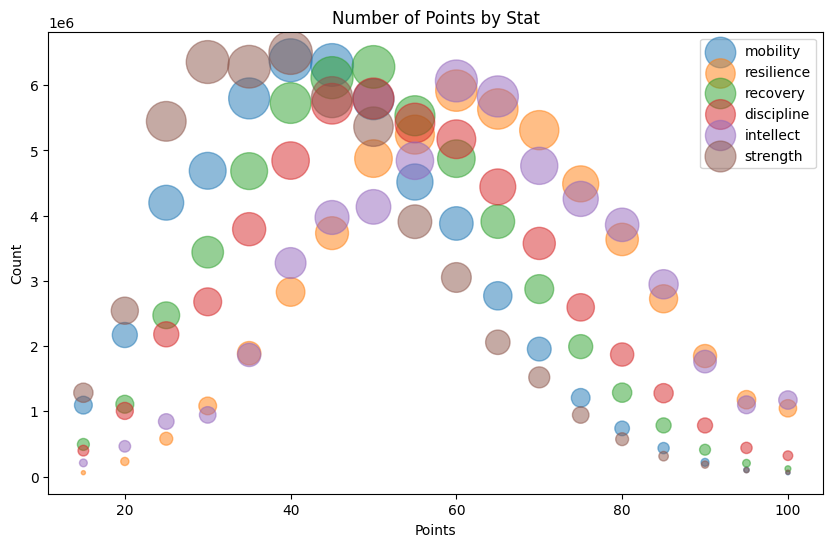

In [38]:
import polars as pl
import matplotlib.pyplot as plt

# Reshape the DataFrame to long format
long_df = outfits_df.melt(
    value_vars=["mobility", "resilience", "recovery", "discipline", "intellect", "strength"],
)

# Rename the columns to 'stat' and 'points'
long_df = long_df.with_columns(
    long_df["variable"].alias("stat"),
    long_df["value"].alias("points"),
)

# Count the number of outfits for each point total for each stat
counts_df = long_df.group_by(["stat", "points"]).agg(pl.count("stat").alias("count"))

# Convert to pandas for easier plotting
counts_df = counts_df.to_pandas()

# Create a scatter plot
plt.figure(figsize=(10, 6))
for stat in ["mobility", "resilience", "recovery", "discipline", "intellect", "strength"]:
    stat_df = counts_df[counts_df["stat"] == stat]
    plt.scatter(
        stat_df["points"],
        stat_df["count"],  # Y-axis
        s=stat_df["count"] * 0.00015,  # Scale the count values for dot size
        alpha=0.5,
        label=stat,
    )
plt.xlabel("Points")
plt.ylabel("Count")
plt.title("Number of Points by Stat")
plt.legend()
plt.show()

### Scratch for testing specific outfits and comparing against DIM

In [25]:
def print_row_weighted_vs_max(row):
    # print the row so that we show the weighted value compared to the weighted max value
    row = row.to_dict()
    for key, value in row.items():
        if not (key.startswith('weighted_') or key.endswith('_max')):
            print(f"{key}: {value[0]}")
        if key.startswith('weighted_') and not key.endswith('_max'):
            max_key = key + '_max'
            real_value = value[0]
            max_value = row[max_key][0]
            if real_value == max_value:
                print(f"{key}: {value[0]} == {row[max_key][0]} ************************************")
            else:
                print(f"{key}: {value[0]} < {row[max_key][0]}")

def print_outfit_stats(row):
    helmet_id = row['helmet'][0]
    gauntlets_id = row['gauntlets'][0]
    chest_id = row['chest_armor'][0]
    leg_id = row['leg_armor'][0]
    class_item_id = row['class_item'][0]

    mobility = 0
    resilience = 0
    recovery = 0
    discipline = 0
    intellect = 0
    strength = 0
    
    for id in [helmet_id, gauntlets_id, chest_id, leg_id, class_item_id]:
        armor = armor_dict[id]
        mobility += armor.mobility
        resilience += armor.resilience
        recovery += armor.recovery
        discipline += armor.discipline
        intellect += armor.intellect
        strength += armor.strength
        print(f"{armor.mobility}\t{armor.resilience}\t{armor.recovery}\t{armor.discipline}\t{armor.intellect}\t{armor.strength}\t{armor.total_stats}\t{armor.is_artifice}\t{armor.item_name}\t{armor.instance_id}")

    print(f"{mobility}\t{resilience}\t{recovery}\t{discipline}\t{intellect}\t{strength}\t<-- base outfit stats")
    print(f"{row['mobility'][0]}\t{row['resilience'][0]}\t{row['recovery'][0]}\t{row['discipline'][0]}\t{row['intellect'][0]}\t{row['strength'][0]}\t<-- outfit with applied artifice + masterwork & rounded to useful tiers")


In [26]:
# find pinnacle_outfits_df rows that have the exotic_hash of 1906093346 - contraverse hold
exotic_hash = 1906093346
helmet_id = 6917529583768023071
gauntlets_id = 6917529936709740897
chest_id = 6917529822099480651
# leg_id = 6917529796979541985
leg_id = 6917529861820030545
class_item_id = 6917529583788947730
filtered_pinnacle_df = pinnacle_outfits_df.filter(
    (pl.col('exotic_hash') == exotic_hash)
    & (pl.col('helmet') == helmet_id)
    & (pl.col('chest_armor') == chest_id)
    # & (pl.col('leg_armor') == leg_id)
    & (pl.col('class_item') == class_item_id)
)
filtered_pinnacle_df


mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,exotic_hash,num_artifice,weighted_mobility,weighted_resilience,weighted_recovery,weighted_discipline,weighted_intellect,weighted_strength,weighted_mobility_resilience,weighted_mobility_recovery,weighted_mobility_discipline,weighted_mobility_intellect,weighted_mobility_strength,weighted_resilience_recovery,weighted_resilience_discipline,weighted_resilience_intellect,weighted_resilience_strength,weighted_recovery_discipline,weighted_recovery_intellect,weighted_recovery_strength,weighted_discipline_intellect,weighted_discipline_strength,weighted_intellect_strength,weighted_mobility_resilience_recovery,weighted_mobility_resilience_discipline,weighted_mobility_resilience_intellect,…,weighted_intellect_max,weighted_strength_max,weighted_mobility_resilience_max,weighted_mobility_recovery_max,weighted_mobility_discipline_max,weighted_mobility_intellect_max,weighted_mobility_strength_max,weighted_resilience_recovery_max,weighted_resilience_discipline_max,weighted_resilience_intellect_max,weighted_resilience_strength_max,weighted_recovery_discipline_max,weighted_recovery_intellect_max,weighted_recovery_strength_max,weighted_discipline_intellect_max,weighted_discipline_strength_max,weighted_intellect_strength_max,weighted_mobility_resilience_recovery_max,weighted_mobility_resilience_discipline_max,weighted_mobility_resilience_intellect_max,weighted_mobility_resilience_strength_max,weighted_mobility_recovery_discipline_max,weighted_mobility_recovery_intellect_max,weighted_mobility_recovery_strength_max,weighted_mobility_discipline_intellect_max,weighted_mobility_discipline_strength_max,weighted_mobility_intellect_strength_max,weighted_resilience_recovery_discipline_max,weighted_resilience_recovery_intellect_max,weighted_resilience_recovery_strength_max,weighted_resilience_discipline_intellect_max,weighted_resilience_discipline_strength_max,weighted_resilience_intellect_strength_max,weighted_recovery_discipline_intellect_max,weighted_recovery_discipline_strength_max,weighted_recovery_intellect_strength_max,weighted_discipline_intellect_strength_max
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
20,100,35,100,50,15,6917529583768023071,6917529936709740897,6917529822099480651,6917529796979541985,6917529583788947730,1906093346,3,500,1220,635,1220,770,455,800,540,800,600,460,860,1120,920,780,860,660,520,920,780,580,630,760,660,…,865,1225,945,825,1075,845,980,950,1135,955,1120,1080,820,945,925,950,825,685,835,735,800,755,630,750,755,785,700,835,710,790,820,830,765,770,785,685,680


In [27]:
print_outfit_stats(filtered_pinnacle_df[0])

2	17	13	20	9	2	63	True	Corrupting Echo Cover	6917529583768023071
2	30	2	28	2	2	66	False	Contraverse Hold	6917529936709740897
6	22	6	20	12	2	68	False	Ketchkiller's Robes	6917529822099480651
2	26	6	22	9	2	67	True	Deep Explorer Boots	6917529796979541985
0	0	0	0	0	0	0	True	Corrupting Echo Bond	6917529583788947730
12	95	27	90	32	8	<-- base outfit stats
20	100	35	100	50	15	<-- outfit with applied artifice + masterwork & rounded to useful tiers


In [28]:
print_row_weighted_vs_max(filtered_pinnacle_df[0])

mobility: 20
resilience: 100
recovery: 35
discipline: 100
intellect: 50
strength: 15
helmet: 6917529583768023071
gauntlets: 6917529936709740897
chest_armor: 6917529822099480651
leg_armor: 6917529796979541985
class_item: 6917529583788947730
exotic_hash: 1906093346
num_artifice: 3
weighted_mobility: 500 < 1175
weighted_resilience: 1220 < 1235
weighted_recovery: 635 < 1135
weighted_discipline: 1220 < 1235
weighted_intellect: 770 < 865
weighted_strength: 455 < 1225
weighted_mobility_resilience: 800 < 945
weighted_mobility_recovery: 540 < 825
weighted_mobility_discipline: 800 < 1075
weighted_mobility_intellect: 600 < 845
weighted_mobility_strength: 460 < 980
weighted_resilience_recovery: 860 < 950
weighted_resilience_discipline: 1120 < 1135
weighted_resilience_intellect: 920 < 955
weighted_resilience_strength: 780 < 1120
weighted_recovery_discipline: 860 < 1080
weighted_recovery_intellect: 660 < 820
weighted_recovery_strength: 520 < 945
weighted_discipline_intellect: 920 < 925
weighted_disc

In [29]:
row = eclipsed_outfits_df.filter(
    (pl.col('exotic_hash') == exotic_hash)
    & (pl.col('helmet') == helmet_id)
    & (pl.col('chest_armor') == chest_id)
    # & (pl.col('leg_armor') == leg_id)
    & (pl.col('class_item') == class_item_id)
).sort('weighted_resilience_discipline_intellect', descending=True)[0]

row

mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,exotic_hash,num_artifice,weighted_mobility,weighted_resilience,weighted_recovery,weighted_discipline,weighted_intellect,weighted_strength,weighted_mobility_resilience,weighted_mobility_recovery,weighted_mobility_discipline,weighted_mobility_intellect,weighted_mobility_strength,weighted_resilience_recovery,weighted_resilience_discipline,weighted_resilience_intellect,weighted_resilience_strength,weighted_recovery_discipline,weighted_recovery_intellect,weighted_recovery_strength,weighted_discipline_intellect,weighted_discipline_strength,weighted_intellect_strength,weighted_mobility_resilience_recovery,weighted_mobility_resilience_discipline,weighted_mobility_resilience_intellect,…,weighted_intellect_max,weighted_strength_max,weighted_mobility_resilience_max,weighted_mobility_recovery_max,weighted_mobility_discipline_max,weighted_mobility_intellect_max,weighted_mobility_strength_max,weighted_resilience_recovery_max,weighted_resilience_discipline_max,weighted_resilience_intellect_max,weighted_resilience_strength_max,weighted_recovery_discipline_max,weighted_recovery_intellect_max,weighted_recovery_strength_max,weighted_discipline_intellect_max,weighted_discipline_strength_max,weighted_intellect_strength_max,weighted_mobility_resilience_recovery_max,weighted_mobility_resilience_discipline_max,weighted_mobility_resilience_intellect_max,weighted_mobility_resilience_strength_max,weighted_mobility_recovery_discipline_max,weighted_mobility_recovery_intellect_max,weighted_mobility_recovery_strength_max,weighted_mobility_discipline_intellect_max,weighted_mobility_discipline_strength_max,weighted_mobility_intellect_strength_max,weighted_resilience_recovery_discipline_max,weighted_resilience_recovery_intellect_max,weighted_resilience_recovery_strength_max,weighted_resilience_discipline_intellect_max,weighted_resilience_discipline_strength_max,weighted_resilience_intellect_strength_max,weighted_recovery_discipline_intellect_max,weighted_recovery_discipline_strength_max,weighted_recovery_intellect_strength_max,weighted_discipline_intellect_strength_max
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
20,100,40,100,45,20,6917529583768023071,6917529936709740897,6917529822099480651,6917529796979541985,6917529583788947730,1906093346,3,505,1225,685,1225,730,505,805,565,805,585,485,885,1125,905,805,885,665,565,905,805,585,645,765,655,…,865,1225,945,825,1075,845,980,950,1135,955,1120,1080,820,945,925,950,825,685,835,735,800,755,630,750,755,785,700,835,710,790,820,830,765,770,785,685,680


In [30]:
row = eclipsed_outfits_df.filter(
    (pl.col('exotic_hash') == exotic_hash)
    & (pl.col('helmet') == helmet_id)
    & (pl.col('chest_armor') == chest_id)
    & (pl.col('leg_armor') == leg_id)
    & (pl.col('class_item') == class_item_id)
).sort('weighted_resilience_discipline_intellect', descending=True)[0]

In [31]:
print(outfits_df.dtypes)
print(outfits_df.shape)
print(outfits_df.describe()) 

[Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64]
(9088688, 54)
shape: (9, 55)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ mobility  ┆ resilienc ┆ recovery  ┆ … ┆ weighted_ ┆ weighted_ ┆ weighted_ ┆ weighted │
│ ---       ┆ ---       ┆ e         ┆ ---       ┆   ┆ recovery_ ┆ recovery_ ┆ recovery_ ┆ _discipl │
│ str       ┆ f64       ┆ ---       ┆ f64       ┆   ┆ disciplin ┆ disciplin ┆ intellect ┆ ine_inte │
│           ┆           ┆ f64       ┆           ┆   ┆ e_i…      ┆ e_s…      ┆ _st…      ┆ llect_…  │
│           ┆           ┆           ┆           ┆   ┆ ---       ┆ ---       ┆ ---      

In [32]:
# find rows in ploutfits_df that are duplicate rows for all fields - should not happen
outfits_df.filter(outfits_df.is_duplicated())

mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,exotic_hash,num_artifice,weighted_mobility,weighted_resilience,weighted_recovery,weighted_discipline,weighted_intellect,weighted_strength,weighted_mobility_resilience,weighted_mobility_recovery,weighted_mobility_discipline,weighted_mobility_intellect,weighted_mobility_strength,weighted_resilience_recovery,weighted_resilience_discipline,weighted_resilience_intellect,weighted_resilience_strength,weighted_recovery_discipline,weighted_recovery_intellect,weighted_recovery_strength,weighted_discipline_intellect,weighted_discipline_strength,weighted_intellect_strength,weighted_mobility_resilience_recovery,weighted_mobility_resilience_discipline,weighted_mobility_resilience_intellect,weighted_mobility_resilience_strength,weighted_mobility_recovery_discipline,weighted_mobility_recovery_intellect,weighted_mobility_recovery_strength,weighted_mobility_discipline_intellect,weighted_mobility_discipline_strength,weighted_mobility_intellect_strength,weighted_resilience_recovery_discipline,weighted_resilience_recovery_intellect,weighted_resilience_recovery_strength,weighted_resilience_discipline_intellect,weighted_resilience_discipline_strength,weighted_resilience_intellect_strength,weighted_recovery_discipline_intellect,weighted_recovery_discipline_strength,weighted_recovery_intellect_strength,weighted_discipline_intellect_strength
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64


In [33]:
# one of my specific outfits I can see in DIM - shows all permutations of this outfit that have unique stat totals
crown_of_tempests_id=6917529798174050595
corrupting_echo_gloves_id=6917529970716463834
ketchkillers_robes_id=6917529822099480651
deep_explorer_boots_id=6917529796979541985
class_item_id=6917529583788947730
outfit = outfits_df.filter(
    (outfits_df['helmet'] == crown_of_tempests_id) & 
    (outfits_df['gauntlets'] == corrupting_echo_gloves_id) & 
    (outfits_df['chest_armor'] == ketchkillers_robes_id) &
    (outfits_df['leg_armor'] == deep_explorer_boots_id) &
    (outfits_df['class_item'] == class_item_id))

outfit

mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,exotic_hash,num_artifice,weighted_mobility,weighted_resilience,weighted_recovery,weighted_discipline,weighted_intellect,weighted_strength,weighted_mobility_resilience,weighted_mobility_recovery,weighted_mobility_discipline,weighted_mobility_intellect,weighted_mobility_strength,weighted_resilience_recovery,weighted_resilience_discipline,weighted_resilience_intellect,weighted_resilience_strength,weighted_recovery_discipline,weighted_recovery_intellect,weighted_recovery_strength,weighted_discipline_intellect,weighted_discipline_strength,weighted_intellect_strength,weighted_mobility_resilience_recovery,weighted_mobility_resilience_discipline,weighted_mobility_resilience_intellect,weighted_mobility_resilience_strength,weighted_mobility_recovery_discipline,weighted_mobility_recovery_intellect,weighted_mobility_recovery_strength,weighted_mobility_discipline_intellect,weighted_mobility_discipline_strength,weighted_mobility_intellect_strength,weighted_resilience_recovery_discipline,weighted_resilience_recovery_intellect,weighted_resilience_recovery_strength,weighted_resilience_discipline_intellect,weighted_resilience_discipline_strength,weighted_resilience_intellect_strength,weighted_recovery_discipline_intellect,weighted_recovery_discipline_strength,weighted_recovery_intellect_strength,weighted_discipline_intellect_strength
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
25,95,40,80,35,50,6917529798174050595,6917529970716463834,6917529822099480651,6917529796979541985,6917529583788947730,3381022969,3,550,1180,685,1045,640,775,805,585,745,565,625,865,1025,845,905,805,625,685,785,845,665,645,725,635,665,615,525,555,605,635,545,755,665,695,745,775,685,635,665,575,655
30,95,40,85,35,50,6917529798174050595,6917529970716463834,6917529822099480651,6917529796979541985,6917529583788947730,3381022969,3,605,1190,695,1100,650,785,835,615,795,595,655,875,1055,855,915,835,635,695,815,875,675,665,755,655,685,645,545,575,635,665,565,775,675,705,765,795,695,655,685,585,675
35,95,40,80,35,50,6917529798174050595,6917529970716463834,6917529822099480651,6917529796979541985,6917529583788947730,3381022969,3,650,1190,695,1055,650,785,855,635,795,615,675,875,1035,855,915,815,635,695,795,855,675,675,755,665,695,645,555,585,635,665,575,765,675,705,755,785,695,645,675,585,665
25,100,45,80,35,50,6917529798174050595,6917529970716463834,6917529822099480651,6917529796979541985,6917529583788947730,3381022969,3,560,1235,740,1055,650,785,835,615,755,575,635,915,1055,875,935,835,655,715,795,855,675,675,745,655,685,635,545,575,615,645,555,785,695,725,765,795,705,655,685,595,665
30,95,40,80,35,55,6917529798174050595,6917529970716463834,6917529822099480651,6917529796979541985,6917529583788947730,3381022969,3,605,1190,695,1055,650,830,835,615,775,595,675,875,1035,855,935,815,635,715,795,875,695,665,745,655,695,635,545,585,625,665,575,765,675,715,755,795,705,645,685,595,675
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
25,95,40,85,35,50,6917529798174050595,6917529970716463834,6917529822099480651,6917529796979541985,6917529583788947730,3381022969,3,555,1185,690,1095,645,780,810,590,770,570,630,870,1050,850,910,830,630,690,810,870,670,650,740,640,670,630,530,560,620,650,550,770,670,700,760,790,690,650,680,580,670
25,100,40,80,40,50,6917529798174050595,6917529970716463834,6917529822099480651,6917529796979541985,6917529583788947730,3381022969,3,560,1235,695,1055,695,785,835,595,755,595,635,895,1055,895,935,815,655,695,815,855,695,665,745,665,685,625,545,565,625,645,565,775,695,715,775,795,715,655,675,595,675
25,100,40,80,35,50,6917529798174050595,6917529970716463834,6917529822099480651,6917529796979541985,6917529583788947730,3381022969,3,555,1230,

# Tests

In [34]:
import unittest
import random
from src.armor import Armor, ProfileArmor, random_64_int
import json

random.seed(42)

class TestOutfits(unittest.TestCase):
    def armor_list_to_dict(self, armor_list):
        return {armor.instance_id: armor for armor in armor_list}

    def random_stat(self):
        return random.randint(1,42)
    
    def random_armor(self, slot, rarity="Legendary", item_hash=None):
        if item_hash is None:
            item_hash = random_64_int()
        return Armor(slot=slot, rarity=rarity, item_hash=item_hash, mobility=self.random_stat(), resilience=self.random_stat(), recovery=self.random_stat(), discipline=self.random_stat(), intellect=self.random_stat(), strength=self.random_stat())
    
    def setUp(self):
        self.titan_helmet = Armor(slot="Helmet", mobility=6, resilience=6, recovery=6, discipline=6, intellect=6, strength=6, d2_class="Titan")
        self.helmet = Armor(slot="Helmet", mobility=6, resilience=6, recovery=6, discipline=6, intellect=6, strength=6)
        self.artifice_helmet = Armor(slot="Helmet", mobility=6, resilience=6, recovery=6, discipline=6, intellect=6, strength=6, is_artifice=True)
        self.gauntlets = Armor(slot="Gauntlets", mobility=7, resilience=7, recovery=7, discipline=7, intellect=7, strength=7)
        self.chest_armor = Armor(slot="Chest Armor", mobility=8, resilience=8, recovery=8, discipline=8, intellect=8, strength=8)
        self.leg_armor = Armor(slot="Leg Armor", mobility=9, resilience=9, recovery=9, discipline=9, intellect=9, strength=9)
        self.artifice_leg_armor = Armor(slot="Leg Armor", mobility=11, resilience=11, recovery=11, discipline=5, intellect=5, strength=20, is_artifice=True)
        self.class_item = Armor(slot="Class Item", mobility=0, resilience=0, recovery=0, discipline=0, intellect=0, strength=0)
        self.exotic_helmet = Armor(slot="Helmet", item_hash=200, rarity="Exotic", mobility=2, resilience=20, recovery=10, discipline=30, intellect=2, strength=2)
        self.exotic_helmet2 = Armor(slot="Helmet", item_hash=300, rarity="Exotic", mobility=11, resilience=11, recovery=11, discipline=11, intellect=11, strength=11)
        self.exotic_gauntlets = Armor(slot="Gauntlets", item_hash=400, rarity="Exotic", mobility=10, resilience=10, recovery=10, discipline=10, intellect=10, strength=10)

        # all armor pieces in a dictionary keyed by instance_id
        self.armor_dict = self.armor_list_to_dict([
            self.titan_helmet,
            self.helmet,
            self.artifice_helmet,
            self.gauntlets,
            self.chest_armor,
            self.leg_armor,
            self.artifice_leg_armor,
            self.class_item,
            self.exotic_helmet,
            self.exotic_helmet2,
            self.exotic_gauntlets
        ])

        # all unspecified stats are zero
        self.helmet_0 = Armor(slot="Helmet")
        self.gauntlets_0 = Armor(slot="Gauntlets")
        self.chest_armor_0 = Armor(slot="Chest Armor")
        self.leg_armor_0 = Armor(slot="Leg Armor")
        self.class_item_0 = Armor(slot="Class Item")

    def test_armor(self):
        armor = self.helmet
        self.assertEqual(armor.total_stats, 36)
        self.assertEqual(armor.class_slot, "Warlock Helmet")
        self.assertFalse(armor.is_exotic)

        exotic_armor = self.exotic_helmet
        self.assertTrue(exotic_armor.is_exotic)

    def test_filter_and_group_armor(self):
        profile_outfits = ProfileOutfits(self.armor_dict)
        exotic_armor, non_exotic_armor = profile_outfits.filter_and_group_armor("Warlock")

        self.assertIsNotNone(exotic_armor)
        self.assertEqual(len(exotic_armor), 2)
        self.assertEqual(exotic_armor["Helmet"], [self.exotic_helmet, self.exotic_helmet2])
        self.assertEqual(exotic_armor["Gauntlets"], [self.exotic_gauntlets])
        self.assertIsNotNone(non_exotic_armor)
        self.assertEqual(len(non_exotic_armor), 5)
        self.assertEqual(non_exotic_armor["Helmet"], [self.helmet, self.artifice_helmet])
        self.assertEqual(non_exotic_armor["Gauntlets"], [self.gauntlets])
        self.assertEqual(non_exotic_armor["Chest Armor"], [self.chest_armor])
        self.assertEqual(non_exotic_armor["Leg Armor"], [self.leg_armor, self.artifice_leg_armor])
        self.assertEqual(non_exotic_armor["Class Item"], [self.class_item])

        exotic_armor, non_exotic_armor = profile_outfits.filter_and_group_armor("Titan")
        self.assertEqual(len(exotic_armor), 0)
        self.assertEqual(len(non_exotic_armor), 1)
        self.assertEqual(non_exotic_armor["Helmet"], [self.titan_helmet])

    def test_generate_class_outfits(self):
        armor_dict = self.armor_list_to_dict([
            self.helmet,
            self.gauntlets,
            self.chest_armor,
            self.leg_armor,
            self.class_item,
            self.exotic_helmet,
            self.exotic_helmet2,
            self.exotic_gauntlets
        ])
        profile_outfits = ProfileOutfits(armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits), 4)

        # point totals would be 44 for each stat, but we round down to the nearest 5 for the tier
        self.assertEqual(outfits[0], (40, 40, 40, 40, 40, 40, self.helmet.instance_id, self.gauntlets.instance_id, self.chest_armor.instance_id, self.leg_armor.instance_id, self.class_item.instance_id, -1, 0))
        self.assertEqual(outfits[1], (35, 50, 40, 60, 35, 35, self.exotic_helmet.instance_id, self.gauntlets.instance_id, self.chest_armor.instance_id, self.leg_armor.instance_id, self.class_item.instance_id, self.exotic_helmet.item_hash, 0))
        self.assertEqual(outfits[2], (45, 45, 45, 45, 45, 45, self.exotic_helmet2.instance_id, self.gauntlets.instance_id, self.chest_armor.instance_id, self.leg_armor.instance_id, self.class_item.instance_id, self.exotic_helmet2.item_hash, 0))
        self.assertEqual(outfits[3], (40, 40, 40, 40, 40, 40, self.helmet.instance_id, self.exotic_gauntlets.instance_id, self.chest_armor.instance_id, self.leg_armor.instance_id, self.class_item.instance_id, 400, 0))

    def test_generate_many_class_outfits(self):
        armor_list=[]
        for i in range(10):
            armor_list.append(self.random_armor("Helmet"))
            armor_list.append(self.random_armor("Gauntlets"))
            armor_list.append(self.random_armor("Chest Armor"))
            armor_list.append(self.random_armor("Leg Armor"))
            armor_list.append(self.random_armor("Class Item"))

        armor_dict = self.armor_list_to_dict(armor_list)
        profile_outfits = ProfileOutfits(armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        # 4 slots with 20 pieces per slot, 10^4 = 10,000
        self.assertEqual(len(outfits), 10**4)

        for i in range(2):
            armor_list.append(self.random_armor("Helmet", "Exotic"))
            armor_list.append(self.random_armor("Gauntlets", "Exotic"))
            armor_list.append(self.random_armor("Leg Armor", "Exotic"))
            armor_list.append(self.random_armor("Chest Armor", "Exotic"))

        armor_dict = self.armor_list_to_dict(armor_list)
        profile_outfits = ProfileOutfits(armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        # same 4 slots with 10 legendary pieces per slot, but now 2 exotic pieces per slot that each need to be combined with 3 slots of 10 legendary pieces 
        self.assertEqual(len(outfits), 10**4 + 8 * 10**3)

    def test_outfit_permutations_zero_artifice(self):
        no_artifice_armor_dict = self.armor_list_to_dict([self.helmet_0, self.gauntlets_0, self.chest_armor_0, self.leg_armor_0, self.class_item_0])

        profile_outfits = ProfileOutfits(no_artifice_armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits), 1)
        # stats in outfit are 10 as we're assuming all armor pieces are masterworked, even though they have all stats at zero
        self.assertEqual(outfits[0], (10, 10, 10, 10, 10, 10, self.helmet_0.instance_id, self.gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 0))

    def test_outfit_permutations_one_artifice_stats_zero(self):
        # if we have one piece of artifice armor, but the 3 points it gives doesn't increase a tier, we'll still only have 1 outfit
        artifice_helmet_0 = Armor(slot="Helmet", is_artifice=True) # all stats still at zero
        one_artifice_armor_dict = self.armor_list_to_dict([artifice_helmet_0, self.gauntlets_0, self.chest_armor_0, self.leg_armor_0, self.class_item_0])

        profile_outfits = ProfileOutfits(one_artifice_armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits), 1)
        self.assertEqual(outfits[0], (10, 10, 10, 10, 10, 10, artifice_helmet_0.instance_id, self.gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 1))

    def test_outfit_permutations_one_artifice_stats_two(self):
        # if we have one piece of artifice armor, but the 2 base points it has are enough to get it close enough to the next tier, we'll have 6 outfits, one for each stat bumped up
        artifice_helmet_2 = Armor(slot="Helmet", mobility=2, resilience=2, recovery=2, discipline=2, intellect=2, strength=2, is_artifice=True)
        one_artifice_armor_dict = self.armor_list_to_dict([artifice_helmet_2, self.gauntlets_0, self.chest_armor_0, self.leg_armor_0, self.class_item_0])

        profile_outfits = ProfileOutfits(one_artifice_armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits), 6)
        self.assertIn((15, 10, 10, 10, 10, 10, artifice_helmet_2.instance_id, self.gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 1), outfits)
        self.assertIn((10, 15, 10, 10, 10, 10, artifice_helmet_2.instance_id, self.gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 1), outfits)
        self.assertIn((10, 10, 15, 10, 10, 10, artifice_helmet_2.instance_id, self.gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 1), outfits)
        self.assertIn((10, 10, 10, 15, 10, 10, artifice_helmet_2.instance_id, self.gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 1), outfits)
        self.assertIn((10, 10, 10, 10, 15, 10, artifice_helmet_2.instance_id, self.gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 1), outfits)
        self.assertIn((10, 10, 10, 10, 10, 15, artifice_helmet_2.instance_id, self.gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 1), outfits)

    def test_outfit_permutations_two_artifice_stats_zero(self):
        # if we have two pieces of artifice armor, but we're starting with all stats ending in 0, we'll get 6 outfits as we can add 6 to each stat
        artifice_helmet_0 = Armor(slot="Helmet", is_artifice=True) # all stats still at zero
        artifice_gauntlets_0 = Armor(slot="Gauntlets", mobility=0, resilience=0, recovery=0, discipline=0, intellect=0, strength=0, is_artifice=True)

        two_artifice_armor_dict = self.armor_list_to_dict([artifice_helmet_0, artifice_gauntlets_0, self.chest_armor_0, self.leg_armor_0, self.class_item_0])

        profile_outfits = ProfileOutfits(two_artifice_armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits), 7)
        self.assertIn((10, 10, 10, 10, 10, 10, artifice_helmet_0.instance_id, artifice_gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((15, 10, 10, 10, 10, 10, artifice_helmet_0.instance_id, artifice_gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 15, 10, 10, 10, 10, artifice_helmet_0.instance_id, artifice_gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 10, 15, 10, 10, 10, artifice_helmet_0.instance_id, artifice_gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 10, 10, 15, 10, 10, artifice_helmet_0.instance_id, artifice_gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 10, 10, 10, 15, 10, artifice_helmet_0.instance_id, artifice_gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 10, 10, 10, 10, 15, artifice_helmet_0.instance_id, artifice_gauntlets_0.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)

    def test_outfit_permutations_two_artifice_stats_two(self):
        # # if we have two pieces of artifice armor, and we start with base stats of 4 in each stat, we'll get permutations we can add either 6 to every stat or 3 to 2 stats
        artifice_helmet_2 = Armor(slot="Helmet", mobility=2, resilience=2, recovery=2, discipline=2, intellect=2, strength=2, is_artifice=True)
        artifice_gauntlets_2 = Armor(slot="Gauntlets", mobility=2, resilience=2, recovery=2, discipline=2, intellect=2, strength=2, is_artifice=True)

        two_artifice_armor_dict = self.armor_list_to_dict([artifice_helmet_2, artifice_gauntlets_2, self.chest_armor_0, self.leg_armor_0, self.class_item_0])

        profile_outfits = ProfileOutfits(two_artifice_armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits), 21)

        self.assertIn((20, 10, 10, 10, 10, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 20, 10, 10, 10, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 10, 20, 10, 10, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 10, 10, 20, 10, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 10, 10, 10, 20, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 10, 10, 10, 10, 20, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)

        self.assertIn((15, 15, 10, 10, 10, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((15, 10, 15, 10, 10, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((15, 10, 10, 15, 10, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((15, 10, 10, 10, 15, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((15, 10, 10, 10, 10, 15, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)

        self.assertIn((10, 15, 15, 10, 10, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 15, 10, 15, 10, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 15, 10, 10, 15, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 15, 10, 10, 10, 15, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)

        self.assertIn((10, 10, 15, 15, 10, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 10, 15, 10, 15, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 10, 15, 10, 10, 15, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)

        self.assertIn((10, 10, 10, 15, 15, 10, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)
        self.assertIn((10, 10, 10, 15, 10, 15, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)

        self.assertIn((10, 10, 10, 10, 15, 15, artifice_helmet_2.instance_id, artifice_gauntlets_2.instance_id, self.chest_armor_0.instance_id, self.leg_armor_0.instance_id, self.class_item_0.instance_id, -1, 2), outfits)

    def test_outfit_permutations_five_artifice_stats(self):
        # if we have five pieces of artifice armor, and we start with base stats of 0 in each stat
        # we'll get permutations we can add:
        # - 15 to one stat - 6 ways 
        # - 12 to one stat and 3 to one stat - 30 ways
        # - 9 to one stat and 6 to one stat - 30 ways
        # - 9 to one stat and 3 to two stats - 60 ways
        # - 6 to two stats and 3 to one stat - 60 ways
        # - 6 to one stat and 3 to three stats - 60 ways
        # - 3 to five stats - 6 ways
        # but! some of those ways don't give us new stat combos because we only care about increments of 5 on a stat
        # if all stats end in 0, adding +3 ~ +0 and +9 ~ +6 - redundant combos can be removed
        # if all stats end in 1, adding +3 ~ +0 and +9 ~ +12
        # if all stats end in 2, adding +6 ~ +3 and +9 ~ +12
        # if all stats end in 3, adding +6 ~ +3 and +12 ~ +15
        # if all stats end in 4, adding +9 ~ +6 and +12 ~ +15
        # stats of 5 loop back to the same as 0

        artifice_helmet_0 = Armor(slot="Helmet", is_artifice=True)
        artifice_helmet_1 = Armor(slot="Helmet", mobility=1, resilience=1, recovery=1, discipline=1, intellect=1, strength=1, is_artifice=True)
        artifice_helmet_2 = Armor(slot="Helmet", mobility=2, resilience=2, recovery=2, discipline=2, intellect=2, strength=2, is_artifice=True)
        artifice_helmet_3 = Armor(slot="Helmet", mobility=3, resilience=3, recovery=3, discipline=3, intellect=3, strength=3, is_artifice=True)
        artifice_helmet_4 = Armor(slot="Helmet", mobility=4, resilience=4, recovery=4, discipline=4, intellect=4, strength=4, is_artifice=True)
        artifice_gauntlets_0 = Armor(slot="Gauntlets", is_artifice=True)
        artifice_chest_0 = Armor(slot="Chest Armor", is_artifice=True)
        artifice_legs_0 = Armor(slot="Leg Armor", is_artifice=True)
        artifice_class_0 = Armor(slot="Class Item", is_artifice=True)

        profile_outfits_0 = ProfileOutfits(self.armor_list_to_dict([artifice_helmet_0, artifice_gauntlets_0, artifice_chest_0, artifice_legs_0, artifice_class_0]))
        outfits_0 = profile_outfits_0.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits_0), 34)

        profile_outfits_1 = ProfileOutfits(self.armor_list_to_dict([artifice_helmet_1, artifice_gauntlets_0, artifice_chest_0, artifice_legs_0, artifice_class_0]))
        outfits_1 = profile_outfits_1.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits_1), 64)

        profile_outfits_2 = ProfileOutfits(self.armor_list_to_dict([artifice_helmet_2, artifice_gauntlets_0, artifice_chest_0, artifice_legs_0, artifice_class_0]))
        outfits_2 = profile_outfits_2.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits_2), 137)

        profile_outfits_3 = ProfileOutfits(self.armor_list_to_dict([artifice_helmet_3, artifice_gauntlets_0, artifice_chest_0, artifice_legs_0, artifice_class_0]))
        outfits_3 = profile_outfits_3.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits_3), 167)

        profile_outfits_4 = ProfileOutfits(self.armor_list_to_dict([artifice_helmet_4, artifice_gauntlets_0, artifice_chest_0, artifice_legs_0, artifice_class_0]))
        outfits_4 = profile_outfits_4.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits_4), 237)
        
        # print outfits_4 to a file in data as json
        with open("data/outfits_4.json", "w") as f:
            json.dump(outfits_4, f, indent=4)



unittest.main(argv=[''], verbosity=2, exit=False)

test_armor (__main__.TestOutfits.test_armor) ... ok
test_filter_and_group_armor (__main__.TestOutfits.test_filter_and_group_armor) ... ok
test_generate_class_outfits (__main__.TestOutfits.test_generate_class_outfits) ... ok
test_generate_many_class_outfits (__main__.TestOutfits.test_generate_many_class_outfits) ... ok
test_outfit_permutations_five_artifice_stats (__main__.TestOutfits.test_outfit_permutations_five_artifice_stats) ... ok
test_outfit_permutations_one_artifice_stats_two (__main__.TestOutfits.test_outfit_permutations_one_artifice_stats_two) ... ok
test_outfit_permutations_one_artifice_stats_zero (__main__.TestOutfits.test_outfit_permutations_one_artifice_stats_zero) ... ok
test_outfit_permutations_two_artifice_stats_two (__main__.TestOutfits.test_outfit_permutations_two_artifice_stats_two) ... ok
test_outfit_permutations_two_artifice_stats_zero (__main__.TestOutfits.test_outfit_permutations_two_artifice_stats_zero) ... ok
test_outfit_permutations_zero_artifice (__main__.Tes